In [19]:
#scoring function complete,rfe,vinson_ce,fong_svm,bcipa,
#iCipa_basic_ends_rep,iCipa_basic_rep,iCipa_basic_ends,iCipa_basic
import os
sfunc = os.environ.get("sfunc", "iCipa_basic_ends_rep")
out_dir = os.environ.get("out_dir", "score_function_comparison")
print(sfunc)
print(out_dir)


iCipa_basic_ends_rep
score_function_comparison


In [20]:
from __future__ import division, absolute_import, print_function
%load_ext autoreload
%autoreload 2


import os 
print(os.getcwd()) 
    
import hepran
import hepran.bzipscore as bz
import hepran.bcipa as bc
import hepran.utils as u
import hepran.registers as r
import hepran.agadir as ag

import pandas as pd
import numpy as np
import seaborn as sns
    
%matplotlib inline

import matplotlib as mpl
import matplotlib.pylab as plt

import sklearn as sk
from IPython.display import display

CCO = os.environ.get("CCO",r"C:\Projekti_KI\ortoCC\CoiledCoilOrtho")


def getRMSE(x, y, df):
    return np.sqrt(((df[x]-df[y])**2).mean())

def get_stats(sc):
    from sklearn import  linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(sc[['score']], sc['Tm'])
    sc_y_pred = regr.predict(sc[['score']])
    RMSE = np.sqrt(mean_squared_error(sc['Tm'], sc_y_pred))
    R = np.sqrt(r2_score(sc['Tm'], sc_y_pred))
    return R, RMSE, regr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
D:\data\ortoCC\fine_tune_scoring_function


In [21]:
df = pd.read_excel('data/round0_fiting.xlsx',index_col=[0,1])
df.head(5);
sc = pd.read_excel('data/mason_both.{sfunc}.score.xlsx'.format(**locals()),index_col=[0,1] )
if not sfunc in "iCipa_basic_ends_rep,iCipa_basic_rep,iCipa_basic_ends,iCipa_basic".split(','):
    sc['score']=sc['score']*-1
sc = sc.join(df['Tm on_target'.split()], lsuffix='_orig')
sc.head(5);
sc_on=sc.query('on_target')

In [22]:
import collections
dd = collections.OrderedDict()
dd['sfunc'] = sfunc

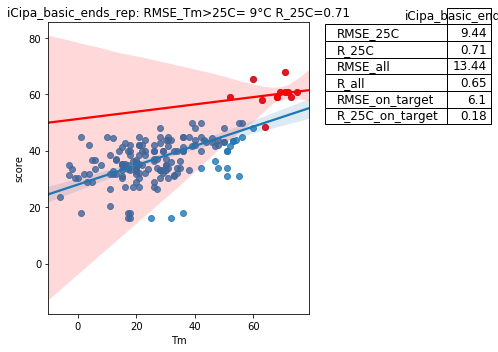

In [23]:

plt.figure(figsize=(7,5))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

sns.regplot(x='Tm', y='score', fit_reg=True, data=sc, ax=ax1)
sns.regplot(x='Tm', y='score', fit_reg=True, data=sc_on, color='red', ax=ax1)




R, RMSE, regr = get_stats(sc)    
dd['RMSE_all'] = RMSE
dd['R_all'] = R

R, RMSE, _ = get_stats(sc.query('Tm > 25'))    
dd['RMSE_25C'] = RMSE
dd['R_25C'] = R

R, RMSE, _ = get_stats(sc.query('on_target'))    
dd['RMSE_on_target'] = RMSE
dd['R_25C_on_target'] = R

# get the coeficients in a dataframe
R_df = np.round(pd.DataFrame.from_dict({sfunc:dd}, orient='index'), 2)
# transpose into row format
R_df = R_df['RMSE_25C R_25C RMSE_all R_all RMSE_on_target R_25C_on_target'.split()].T

#display(R_df)
import pandas.plotting 
ax2.axis('off')
pandas.plotting.table(ax2, R_df,  loc="top", bbox=[.6, .65, .5, .4])
ax2.tables[0].set_fontsize(12)
ax2.tables[0].auto_set_font_size(False)

fig_name = "score_vs_TM"
fig_path = os.path.join(out_dir, sfunc+"_"+fig_name+".png")

dd[fig_name] = fig_path
title = u"{sfunc}: RMSE_Tm>25C={RMSE_25C:2.0f}°C R_25C={R_25C:2.2f}".format(**dd)
ax1.set_title(title)

plt.tight_layout()
plt.savefig(fig_path, dpi=300)


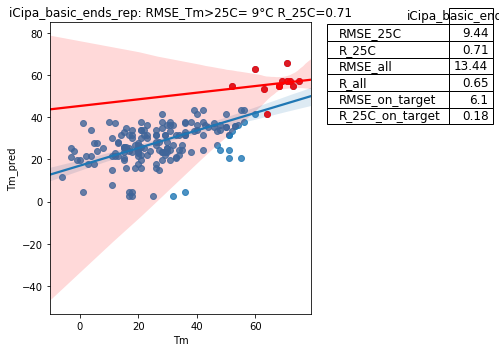

In [24]:
plt.figure(figsize=(7,5))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

sns.regplot(x=sc['Tm'], y=regr.predict(sc[['score']]), fit_reg=True, ax=ax1)
sns.regplot(x=sc_on['Tm'], y=regr.predict(sc_on[['score']]), fit_reg=True, color='red', ax=ax1)

ax1.set_ylabel('Tm_pred')
ax1.set_title(title)

ax2.axis('off')
pandas.plotting.table(ax2, R_df,  loc="top", bbox=[.6, .65, .5, .4])
ax2.tables[0].set_fontsize(12)
ax2.tables[0].auto_set_font_size(False)

fig_name = "Tm_pred_vs_TM"
fig_path = os.path.join(out_dir, sfunc+"_"+fig_name+".png")

dd[fig_name] = fig_path
plt.tight_layout()
plt.savefig(fig_path, dpi=300)

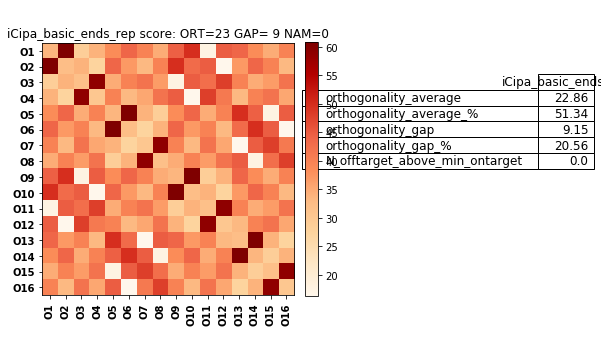

In [25]:
plt.figure(figsize=(7,5))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

pairs = u.load_set_file('data/mason.set')
ids = u.get_ids_from_fasta('data/mason.fasta')
N = len(ids)
mat = u.dataframe_to_array(sc['score'], ids) 

bz.plot_matrix_mpl(mat, ids, cmap='OrRd', title='bCipa',ax=ax1);
set_info = bz.get_set_info('data/mason.set', 'data/mason.fasta', mat, lower_is_better=False)

dd['set_info_score'] = set_info


# get the coeficients in a dataframe
R_df = np.round(pd.DataFrame.from_dict({sfunc:set_info}, orient='index'), 2)
# transpose into row format
R_df = R_df['orthogonality_average orthogonality_average_% \
            orthogonality_gap orthogonality_gap_% N_offtarget_above_min_ontarget'.split()].T
#display(R_df)
ax2.axis('off')
pandas.plotting.table(ax2, R_df,  bbox=[1.5, .5, .5, .3])
ax2.tables[0].set_fontsize(12)
ax2.tables[0].auto_set_font_size(False)

fig_name = "CCset_score"
fig_path = os.path.join(out_dir, sfunc+"_"+fig_name+".png")

dd[fig_name] = fig_path
title = u"{sfunc} score: ORT={orthogonality_average:2.0f} GAP={orthogonality_gap:2.0f} NAM={N_offtarget_above_min_ontarget}".format(sfunc=sfunc,**set_info)
ax1.set_title(title)

plt.tight_layout()
plt.savefig(fig_path, dpi=300)

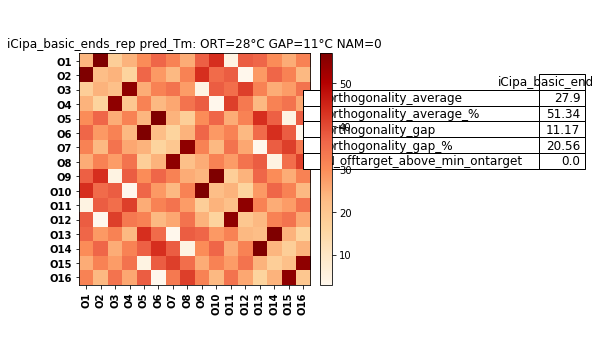

In [26]:
plt.figure(figsize=(7,5))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

pairs = u.load_set_file('data/mason.set')
ids = u.get_ids_from_fasta('data/mason.fasta')
N = len(ids)
mat = u.dataframe_to_array(sc['score'], ids) 

mat_pred=regr.predict(mat.reshape((N*N,1))).reshape((N,N))
bz.plot_matrix_mpl(mat_pred, ids, cmap='OrRd', title='bCipa',ax=ax1);
set_info = bz.get_set_info('data/mason.set', 'data/mason.fasta', mat_pred, lower_is_better=False)

dd['set_info_pred_Tm'] = set_info


# get the coeficients in a dataframe
R_df = np.round(pd.DataFrame.from_dict({sfunc:set_info}, orient='index'), 2)
# transpose into row format
R_df = R_df['orthogonality_average orthogonality_average_% \
            orthogonality_gap orthogonality_gap_% N_offtarget_above_min_ontarget'.split()].T
#display(R_df)
ax2.axis('off')
pandas.plotting.table(ax2, R_df,  bbox=[1.5, .5, .5, .3])
ax2.tables[0].set_fontsize(12)
ax2.tables[0].auto_set_font_size(False)

fig_name = "CCset_pred_Tm"
fig_path = os.path.join(out_dir, sfunc+"_"+fig_name+".png")

dd[fig_name] = fig_path
title = u"{sfunc} pred_Tm: ORT={orthogonality_average:2.0f}°C GAP={orthogonality_gap:2.0f}°C NAM={N_offtarget_above_min_ontarget}".format(sfunc=sfunc,**set_info)
ax1.set_title(title)

plt.tight_layout()
plt.savefig(fig_path, dpi=300)

In [27]:
json_path = os.path.join(out_dir, sfunc+".json")
pd.DataFrame.from_dict({sfunc:dd}, orient='index').to_json(json_path)